In [1]:
from src.data import load_dataset
import tensorflow as tf
from keras import layers
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
(train_ds, val_ds, test_ds), ds_info = load_dataset()

понадобится для сравнения

In [3]:
[data] = train_ds.skip(2).take(1)

unprocessed_image = data["image"]
unprocessed_fine_label = data["label"]
unprocessed_coarse_label = data["coarse_label"]

In [4]:
ds_info.features["coarse_label"].names

['aquatic_mammals',
 'fish',
 'flowers',
 'food_containers',
 'fruit_and_vegetables',
 'household_electrical_devices',
 'household_furniture',
 'insects',
 'large_carnivores',
 'large_man-made_outdoor_things',
 'large_natural_outdoor_scenes',
 'large_omnivores_and_herbivores',
 'medium_mammals',
 'non-insect_invertebrates',
 'people',
 'reptiles',
 'small_mammals',
 'trees',
 'vehicles_1',
 'vehicles_2']

In [5]:
ds_info.features["label"].names[:20]

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle']

In [6]:
from src.labels_maps import coarse_int2str, coarse_str2int, fine_int2str, fine_str2int

print(f"Coarse: {coarse_int2str[5]} - {coarse_str2int['household_electrical_devices']}")
print(f"Fine: {fine_int2str[42]} - {fine_str2int['leopard']}")

Coarse: household_electrical_devices - 5
Fine: leopard - 42


### Чистим ненужные фичи

In [7]:
@tf.function
def drop_and_rename_features(inputs):
    return {
        "image": inputs["image"],
        "fine_label": inputs["label"],
        "coarse_label": inputs["coarse_label"],
    }


train_ds = train_ds.map(drop_and_rename_features)

### Делаем one-hot для меток классов

In [8]:
def build_label_encoder(name: str, num_classes: int):
    layer = layers.IntegerLookup(
        vocabulary=np.arange(start=0, stop=num_classes),
        max_tokens=num_classes,
        num_oov_indices=0,
        vocabulary_dtype=tf.int64,
        output_mode="one_hot",
        dtype=tf.int32,
    )

    return tf.function(
        lambda feature: {**feature, name: tf.cast(layer(feature[name]), tf.uint8)}
    )


label_encoding_layer = build_label_encoder("fine_label", 100)
coarse_label_encoding_layer = build_label_encoder("coarse_label", 20)

train_ds = train_ds.map(label_encoding_layer, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(
    coarse_label_encoding_layer,
    num_parallel_calls=tf.data.AUTOTUNE,
)

### Нормализация изображений

In [9]:
@tf.function
def image_augmentation(inputs):
    image = inputs["image"]
    image = tf.image.per_image_standardization(image)
    return {**inputs, "image": image}


train_ds = train_ds.map(image_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

### Убираем имена столбцов и маппим в tuple

In [10]:
@tf.function
def map_to_tuple(inputs):
    return (inputs["image"], inputs["fine_label"], inputs["coarse_label"])


train_ds = train_ds.map(map_to_tuple)

### Тестируем пайплайн

In [11]:
train_ds = train_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)

In [12]:
tfds.benchmark(train_ds)

tfds.benchmark(train_ds)


************ Summary ************



  0%|          | 0/2 [00:00<?, ?it/s]

Examples/sec (First included) 8.77 ex/sec (total: 3 ex, 0.34 sec)
Examples/sec (First only) 3.00 ex/sec (total: 1 ex, 0.33 sec)
Examples/sec (First excluded) 224.95 ex/sec (total: 2 ex, 0.01 sec)

************ Summary ************



  0%|          | 0/2 [00:00<?, ?it/s]

Examples/sec (First included) 134.21 ex/sec (total: 3 ex, 0.02 sec)
Examples/sec (First only) 45.74 ex/sec (total: 1 ex, 0.02 sec)
Examples/sec (First excluded) 4071.07 ex/sec (total: 2 ex, 0.00 sec)


BenchmarkResult(stats=             duration  num_examples          avg
first+lasts  0.022354             3   134.206259
first        0.021862             1    45.740672
lasts        0.000491             2  4071.072789, raw_stats=                      duration
start_time        32251.367028
first_batch_time  32251.388890
end_time          32251.389381
num_iter              2.000000)

### Пример стандартизации

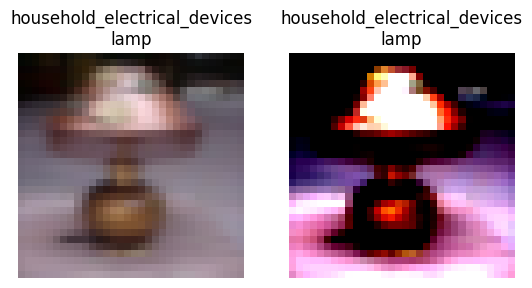

<Figure size 300x600 with 0 Axes>

In [13]:
[(image_batch, fine_label_batch, coarse_label_batch)] = train_ds.take(1)

image = image_batch[2]
fine_label = np.argmax(fine_label_batch[2])
coarse_label = np.argmax(coarse_label_batch[2])

fig, (ax1, ax2) = plt.subplots(1, 2)

plt.figure(figsize=(3, 6))

ax1.imshow(unprocessed_image)
ax1.axis("off")
ax1.set_title(
    f"{coarse_int2str[unprocessed_coarse_label]}\n{fine_int2str[unprocessed_fine_label]}"
)

ax2.imshow(image)
ax2.axis("off")
ax2.set_title(f"{coarse_int2str[coarse_label]}\n{fine_int2str[fine_label]}")

plt.show()

### Сохранение датасета

In [14]:
train_ds.save("../data/processed/train")

In [15]:
loaded_train_ds = tf.data.Dataset.load("../data/processed/train")

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 7067130807001118532


In [16]:
loaded_train_ds.element_spec

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 100), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None, 20), dtype=tf.uint8, name=None))

In [17]:
[data] = loaded_train_ds.take(1)

data

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 7067130807001118532


(<tf.Tensor: shape=(64, 32, 32, 3), dtype=float32, numpy=
 array([[[[ 1.43578792e+00,  1.49996161e+00,  1.30744064e+00],
          [ 1.28604937e+00,  1.35022306e+00,  1.09352851e+00],
          [ 1.22187579e+00,  1.26465821e+00,  1.07213724e+00],
          ...,
          [-8.53072166e-01, -9.81419444e-01, -9.60028231e-01],
          [ 6.01530492e-01,  3.44835907e-01,  2.59271055e-01],
          [ 1.30744064e+00,  9.22398746e-01,  7.72660255e-01]],
 
         [[ 1.47857034e+00,  1.54274404e+00,  1.41439676e+00],
          [ 1.22187579e+00,  1.28604937e+00,  1.09352851e+00],
          [ 1.17909336e+00,  1.24326694e+00,  1.11491966e+00],
          ...,
          [-3.39682966e-01, -5.32203913e-01, -5.32203913e-01],
          [ 1.00796366e+00,  6.22921705e-01,  4.73183215e-01],
          [ 7.94051468e-01,  3.66227150e-01,  2.16488630e-01]],
 
         [[ 1.69248247e+00,  1.73526490e+00,  1.64970005e+00],
          [ 1.41439676e+00,  1.47857034e+00,  1.30744064e+00],
          [ 1.35022306e+

In [18]:
tfds.benchmark(loaded_train_ds)

tfds.benchmark(loaded_train_ds)


************ Summary ************



[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 7067130807001118532


  0%|          | 0/2 [00:00<?, ?it/s]

Examples/sec (First included) 34.45 ex/sec (total: 3 ex, 0.09 sec)
Examples/sec (First only) 11.94 ex/sec (total: 1 ex, 0.08 sec)
Examples/sec (First excluded) 597.61 ex/sec (total: 2 ex, 0.00 sec)

************ Summary ************



  0%|          | 0/2 [00:00<?, ?it/s]

Examples/sec (First included) 39.33 ex/sec (total: 3 ex, 0.08 sec)
Examples/sec (First only) 13.56 ex/sec (total: 1 ex, 0.07 sec)
Examples/sec (First excluded) 790.34 ex/sec (total: 2 ex, 0.00 sec)


BenchmarkResult(stats=             duration  num_examples         avg
first+lasts  0.076275             3   39.331245
first        0.073745             1   13.560302
lasts        0.002531             2  790.337336, raw_stats=                      duration
start_time        32257.775807
first_batch_time  32257.849552
end_time          32257.852083
num_iter              2.000000)